# Auto-correlative Functions and Correlograms

When working with time series data, there are a number of important diagnostics one should consider to help understand more about the data.  The auto-correlative function, plotted as a correlogram, helps explain how a given observations relates to recent preceeding observations.  A very random process (like lottery numbers) would show very low values, while temperature (our topic in this episode) does correlate highly with recent days.

In [37]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import trulia.stats
import geocoder
import json
from datetime import timedelta
from collections import defaultdict
import time
import requests
from statsmodels.graphics import tsaplots
import ConfigParser as cp

In [7]:
cparser = cp.ConfigParser()
cparser.readfp(open('config.properties'))
api_key = cparser.get('weather', 'api_key')

In [8]:
cache = defaultdict(str)

In [10]:
g = geocoder.google('Chapel Hill, NC')

In [12]:
sd = '2010-01-01'
ed = '2016-04-16'
sd2 = pd.to_datetime(sd).to_datetime()
ed2 = pd.to_datetime(ed).to_datetime()

In [16]:
# This is long running, so I like to cache it, walk away, and come back to my nice dataset

x = sd2 + timedelta(hours=9)
while x < datetime.now():
    url = 'https://api.forecast.io/forecast/{}/{},{},{}'.format(api_key, g.lat, g.lng, x.strftime("%Y-%m-%dT%H:%M:%S"))
    if cache[url] == '':
        r2 = requests.get(url)
        time.sleep(.2)
        resp = json.loads(r2.content)
        cache[url] = resp
    x = x + timedelta(days=1)

In [17]:
times = []
temps = []
x = sd2 + timedelta(hours=9)
while x < datetime.now():
    url = 'https://api.forecast.io/forecast/{}/{},{},{}'.format(api_key, g.lat, g.lng, x.strftime("%Y-%m-%dT%H:%M:%S"))
    resp = cache[url]
    times.append(x)
    temps.append(resp['currently']['temperature'])
    x = x + timedelta(days=1)

In [18]:
df2 = pd.DataFrame({'time': times, 'temp': temps})
df2.set_index('time', inplace=True)

Below is a time series of the weather in Chapel Hill, NC every morning over a few years.  You can clearly see an annual cyclic pattern, which should be no suprise to anyone.  Yet, you can also see a fair amount of variance from day to day.  Even if you de-trend the annual cycle, we can see that this would not be enough for yesterday's temperature to perfectly predict today's weather.

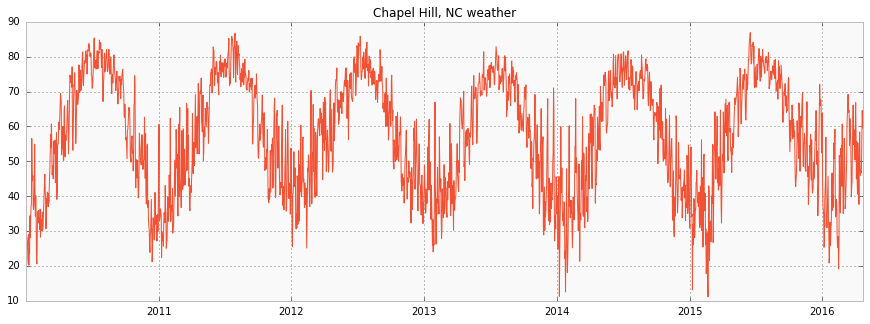

In [19]:
plt.figure(figsize=(15,5))
plt.plot(df2)
plt.title('Chapel Hill, NC weather')
plt.show()

Below is a correlogram of the ACF (auto-correlative function).  For very low values of lag (comparing the most recent temperature measurement to the values of previous days), we can see a quick drop-off.  This tells us that weather correlates very highly, but decliningly so, with recent days.

Interestingly, we also see it negatively correlate with days far away.  This is because of the "opposite" seasons we experience.  The annual cycle of the planet is visible as we see weaker correlations with previous years.

This highlights one limit to the ACF.  If compares the current weather to all previous days and reports those correlations independently.  If we know today and yesterday's weather, the weather from two days ago might not add as much information.

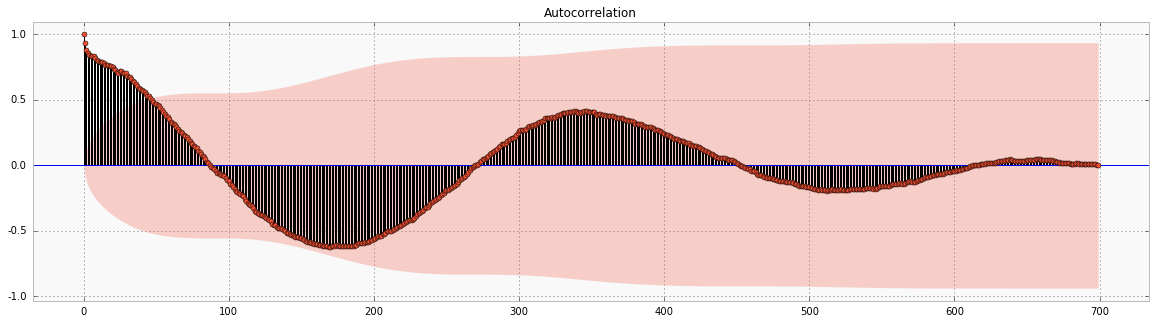

In [30]:
fig = tsaplots.plot_acf(df2[0:700], ax=None)
fig.set_figwidth(20)
fig.set_figheight(5)

For that reason, we also want to review the PACF (partial auto-correlative function) which subtracts the correlation of previous days for each lag so that we get an estimate of what each of those days actually contributes to the most recent observation.  In the plots below of the same data, we see all the seasonal and annual correlations disappear.  We expect this because most of the information about how the weather depends on the past is already contained in the most recent few days.

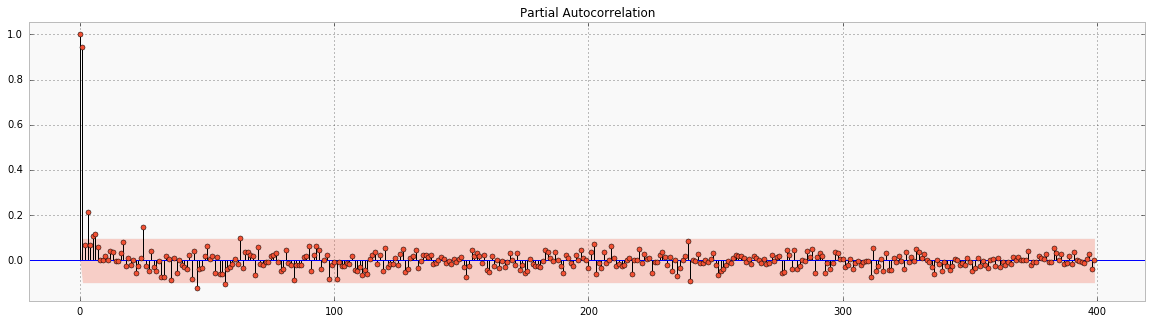

In [31]:
fig = tsaplots.plot_pacf(df2[0:400], ax=None)
fig.set_figwidth(20)
fig.set_figheight(5)

The boundaries shown in the above plots represent a measure of statistical significant.  Any points outside this rang are considered statistically significant.  Those below it are not.

As many listeners know, Kyle and Linhda are looking to by a house.  In fact, they've made an offer on a house in the zipcode 90008.  Thanks to the Trulia API, we can get a time series of the average median listing price of homes in that zipcode and see if it gives us any insight into the viability of this investment's future!

In [32]:
cparser = cp.ConfigParser()
cparser.readfp(open('config.properties'))
tkey = cparser.get('trulia', 'key')
zc = '90008'
data = trulia.stats.TruliaStats(tkey).get_zip_code_stats(zip_code=zc, start_date=sd, end_date=ed)

In [33]:
weeks = []
medians = []
for week in data['listingStats']['listingStat']:
    weeks.append(week['weekEndingDate'])
    medians.append(week['listingPrice']['subcategory'][0]['medianListingPrice'])

In [34]:
df = pd.DataFrame({'week': weeks, 'medianPrice': medians})
df['week'] = pd.to_datetime(df['week'])
df['medianPrice'] = df['medianPrice'].astype(float)
df.sort('week', inplace=True)
df.set_index('week', inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


The plot below shows the time series of the median listing price (note, that's not the same as the sale price) on a daily basis over the past few years.

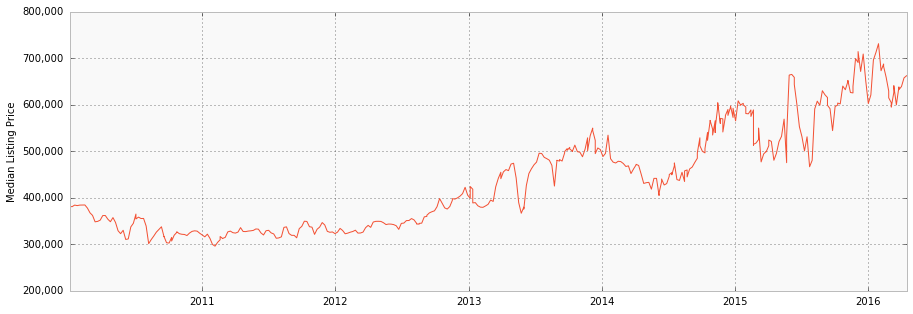

In [43]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.ylabel('Median Listing Price')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

Let's first take a look at it's ACF below.  For price, we see (no suprise) that recent listing prices are pretty good predictors of current listing prices.  Unless some catastrophy or major event (like discovery of oil or a large gold vein) changed things overnight, home prices should have relatively stable short term prices, and therefore, be very auto-correlative.

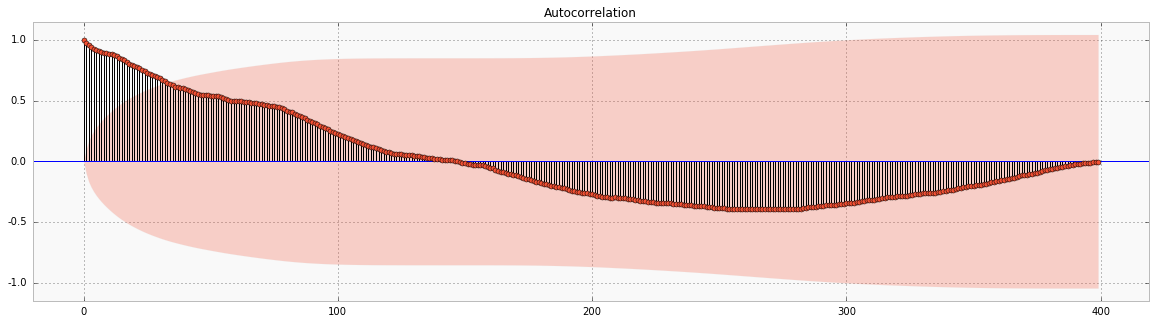

In [44]:
fig = tsaplots.plot_acf(df, ax=None)
fig.set_figwidth(20)
fig.set_figheight(5)

As we did previously, we now want to look at the PACF (below) which shows us that the two most recent days have the most useful information.  Although not suprising, I was wondering if we might find some interesting effects related to houses being listed on weekdays vs. weekends, or at specific times of the month.  However, it seems that when dealing with such large amounts of money, people have a bit more patience.  Perhaps selling a car or a smaller item might show some periodic lags, but the home prices do not.

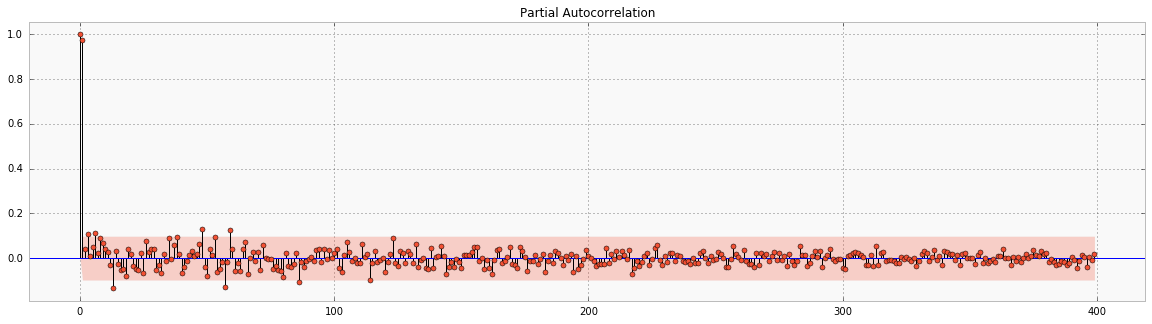

In [41]:
fig = tsaplots.plot_pacf(df, ax=None)
fig.set_figwidth(20)
fig.set_figheight(5)